### Visualize KDN Posterior Probabilities for Multi-class Classification Problems

In [1]:
from tensorflow import keras
from kdg.utils import multiclass_guassian as generate_data
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from kdg.kdn import *

In [6]:
X, y = generate_data(10000, k=3)
X_val, y_val = generate_data(500, k=3)
X_test, y_test = generate_data(1000, k=3)

In [11]:
# Define NN parameters
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=False)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 64,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [9]:
# network architecture [10, 10, 10, 10, 2]
def getNN():
    network_base = keras.Sequential()
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=3, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [12]:
# train Vanilla NN
nn = getNN()
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

In [13]:
# kdn approx lin
kdn_kwargs = {
    "h": 1/3,
    "k": 1e-5,
    "T": 1e-3
}

In [14]:
model_kdn = kdn(nn, **kdn_kwargs)

In [15]:
model_kdn.fit(X, y)

In [16]:
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [29]:
proba_nn = nn.predict(grid_samples)

In [30]:
proba_kdn, likelihoods = model_kdn.predict_proba(grid_samples, return_likelihoods=True)

In [96]:
kdn_max_conf = np.max(proba_kdn, axis=1)
nn_max_conf = np.max(proba_nn, axis=1)
kdn_max_conf = np.flip(kdn_max_conf.reshape(400, 400), axis=0)
nn_max_conf = np.flip(nn_max_conf.reshape(400, 400), axis=0)

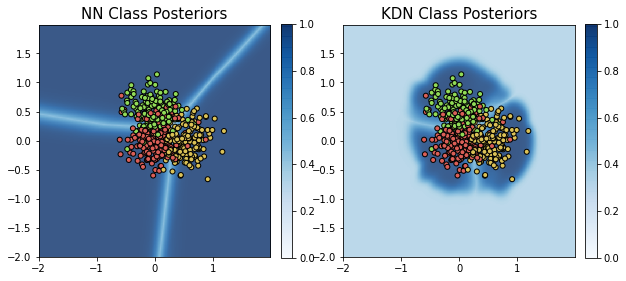

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
colors = sns.color_palette("hls", n_colors=8)
clr = [colors[i] for i in y_val]

ax0 = ax[0].imshow(
    nn_max_conf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Blues",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
    alpha=0.8,
)
ax[0].scatter(X_val[:, 0], X_val[:, 1], c=clr, s=25, edgecolors='k', alpha=1)
ax[0].set_title("NN Class Posteriors", fontsize=15)
ax[0].set_aspect("equal")
fig.colorbar(ax0, ax=ax[0], fraction=0.046, pad=0.04)

ax1 = ax[1].imshow(
    kdn_max_conf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Blues",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
    alpha=0.8,
)
ax[1].scatter(X_val[:, 0], X_val[:, 1], c=clr, s=25, edgecolors='k', alpha=1)

ax[1].set_title("KDN Class Posteriors", fontsize=15)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)